<a href="https://colab.research.google.com/github/isayalimali/Android-HogSafe/blob/master/AI_Symptom_FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df = pd.read_csv("AI Export.csv",header=0)
df

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AI_DATE,AC_MODEL,AC_SN,OPERATOR_CODE,EVENT_RECORD_IDENTIFIER,DIVERTED_LANDING,AIR_TURN_BACK,REJECTED_TAKE_OFF,GROUND_TURN_BACK,ABORTED_APPROACH,EMERGENCY_DESCENT,SMOKE,EMERGENCY_LANDING,INFLIGHT_SHUTDOWN,GEN_AIR_INTERRUPT,GEN_GROUND_INTERRUPT,ATA_SYMPTOM,ATA_CAUSE,INTERRUPTION_REASON,CORRECTIVE_ACTION,AI_ID,EDIT_DATE,EDITED_BY
0,29-Mar-20,CRJ700,15299,EDV,NaN,N,N,N,Y,N,N,N,N,N,N,N,3081,308102,ICE DET (X) FAIL - STATUS,DEFERRED - REPLACED ICE DETECTOR,590931.0,13-May-20,T12540
1,30-Mar-20,CRJ700,15125,EDV,NaN,N,N,N,Y,N,N,N,N,N,N,N,2431,243101,TRU FAN FAIL - STATUS,DEFERRED - REPLACED TRU,590932.0,13-May-20,T12540
2,30-Mar-20,CRJ700,10176,EDV,NaN,N,N,N,Y,N,N,N,N,N,N,N,3613,361315,ISOL FAIL - CAUTION,REPLACED ISOLATION VALVE,590933.0,13-May-20,T12540
3,03-Apr-20,CRJ700,15046,JZA,NaN,N,N,N,Y,N,N,N,N,N,N,N,3022,302201,Incident: RTRN L COWL ANTI ICE CAUTION MSG. L ...,(Resolved On W/O: 684248 Taskcard: NR-00001 ) ...,591076.0,27-May-20,T12540
4,08-Apr-20,CRJ700,15044,JZA,NaN,N,N,N,Y,N,N,N,N,N,N,N,213108,213108,Incident: RTRN OVBD COOL CAUTION MESSAGE DISPL...,(Resolved On W/O: 684350 Taskcard: NR-00001 ) ...,591077.0,27-May-20,T12540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36945,29-Mar-16,CRJ700,10155,ASQ,A651402,N,N,N,Y,N,N,N,N,N,N,N,2824,282426,APU SOV FAIL CAUTION MESSAGE [GATE RETURN]...F...,REMOVED AND REPLACED APU FUEL SOV OPS CHECK GO...,556465.0,29-Jun-17,T582551
36946,14-Mar-16,CRJ700,10151,ASQ,A665443,N,N,N,Y,N,N,N,N,N,N,N,2725,276105,"RUD LIMIT FAULT [GATE RETURN]...FLT 5164, 5586 CX",REMOVED AND REPLACED #2 SSCU IAW CRJ 700 AMM 2...,556466.0,29-Jun-17,T582551
36947,16-Aug-20,CRJ,7510,SKW,877808,N,Y,N,N,N,N,N,N,N,N,N,2751,275102,Flap fail caution during climb out returned to...,This discrepancy was transferred to CAMP item ...,591567.0,18-Sep-20,K0624697
36948,20-Aug-20,CRJ,7555,SKW,879869,N,Y,N,N,N,N,N,N,N,N,N,240,240,On our takeoff roll out of Dickinson we ingest...,Bird strike inspection complied with by contra...,591568.0,18-Sep-20,K0624697


In [3]:

for col in df.columns:
    print(col)

AI_DATE
AC_MODEL
AC_SN
OPERATOR_CODE
EVENT_RECORD_IDENTIFIER
DIVERTED_LANDING
AIR_TURN_BACK
REJECTED_TAKE_OFF
GROUND_TURN_BACK
ABORTED_APPROACH
EMERGENCY_DESCENT
SMOKE
EMERGENCY_LANDING
INFLIGHT_SHUTDOWN
GEN_AIR_INTERRUPT
GEN_GROUND_INTERRUPT
ATA_SYMPTOM
ATA_CAUSE
INTERRUPTION_REASON
CORRECTIVE_ACTION
AI_ID
EDIT_DATE
EDITED_BY


In [4]:
from io import StringIO

col = ['ATA_SYMPTOM', 'INTERRUPTION_REASON']
df = df[col]
df = df[pd.notnull(df['INTERRUPTION_REASON'])]
df.columns = ['ATA_SYMPTOM', 'INTERRUPTION_REASON']
df['category_id'] = df['ATA_SYMPTOM'].factorize()[0]
category_id_df = df[['ATA_SYMPTOM', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'ATA_SYMPTOM']].values)
df

,ATA_SYMPTOM,INTERRUPTION_REASON,category_id
0,3081,ICE DET (X) FAIL - STATUS,0
1,2431,TRU FAN FAIL - STATUS,1
2,3613,ISOL FAIL - CAUTION,2
3,3022,Incident: RTRN L COWL ANTI ICE CAUTION MSG. L ...,3
4,213108,Incident: RTRN OVBD COOL CAUTION MESSAGE DISPL...,4
...,...,...,...
36945,2824,APU SOV FAIL CAUTION MESSAGE [GATE RETURN]...F...,416
36946,2725,"RUD LIMIT FAULT [GATE RETURN]...FLT 5164, 5586 CX",412
36947,2751,Flap fail caution during climb out returned to...,345
36948,240,On our takeoff roll out of Dickinson we ingest...,378


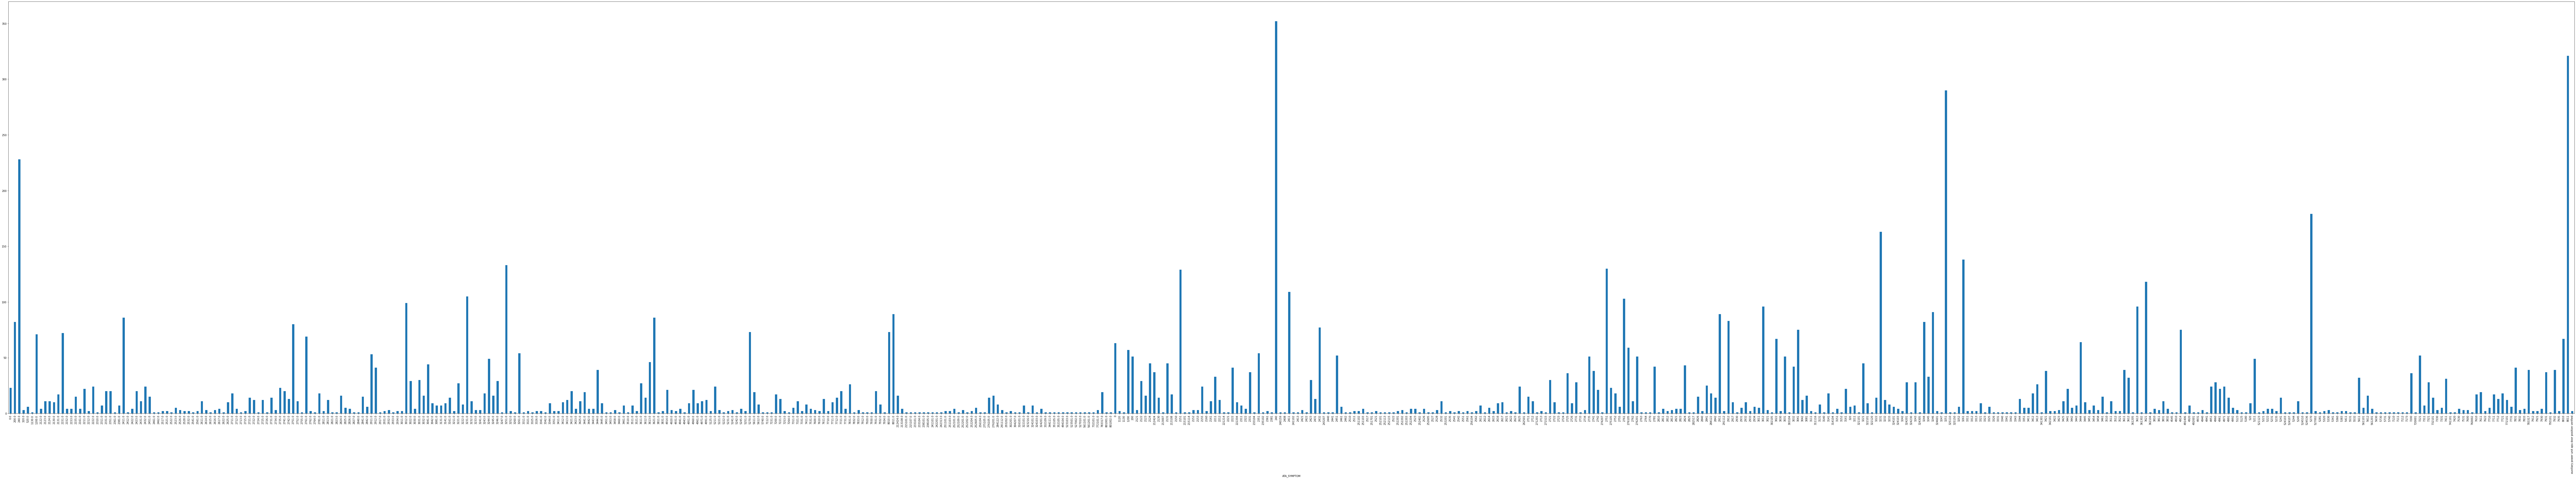

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(182,30))
df.groupby('ATA_SYMPTOM').INTERRUPTION_REASON.count().plot.bar(ylim=0)
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(5, 6), stop_words='english')

features = tfidf.fit_transform(df.INTERRUPTION_REASON).toarray()
labels = df.category_id

features.shape

(36950, 2909)

In [7]:
from sklearn.feature_selection import chi2
import numpy as np
#decides number of features
N = 2
for ATA_SYMPTOM, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  five_features = [v for v in feature_names if len(v.split(' ')) == 5]
  six_features= [v for v in feature_names if len(v.split(' ')) == 6]
  print("# '{}':".format(ATA_SYMPTOM))
  print("  . Most correlated five features:\n. {}".format('\n. '.join(five_features[-N:])))
  print("  . Most correlated six features:\n. {}".format('\n. '.join(six_features[-N:])))

TypeError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
#import seaborn as sns
#sns.boxplot(x='model_name', y='accuracy', data=cv_df)
#sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
 #             size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.show()

NameError: ignored

In [ ]:
cv_df.groupby('model_name').accuracy.mean()